#### Overview


This is Rob's notebook for experimenting with DAS data without muddling up some other notebook. 


- `pip install minio` worked; opened jupyter-lab, started this nbk
    - [minio API documentation](https://min.io/docs/minio/linux/developers/python/API.html)
- placed credentials outside the repo; reads them; instantiate a minio `client`
- list: `buckets = client.list_buckets()`. These include the source HDF5 bucket `OOI-DAS-HDF5`
- list object_name for objects in this bucket; download the first one
    - Ten files, contiguous time: 02-NOV-2021, Time 00:00:14, 01:14 etc in one-minute intervals
    - One file: 200 Hz, one minute, 12,000 pulses; 47,500 channels per pulse (5 meters?)
- open the file using `xarray.open_dataset()`
    - this is challenging owing to the intrinsic heirarchy of the datafile
    - a useful tool to know about is [datatree](https://github.com/xarray-contrib/datatree)
    - the idea is that within the file is a folder structure; but using the term 'groups'


## Data acquisition to local copy


This is set up to work on the UW network only. There are ten files readily 
available comprising ten minutes of data (check this).

In [1]:
from minio import Minio

with open('./../../.minio/k.txt', 'r') as file:
    keys = file.read().split(' ')

client = Minio("pnwstore1.ess.washington.edu:9000", keys[0], keys[1], secure=False)

In [4]:
# at UW only: buckets = client.list_buckets()

`buckets = client.list_buckets()`

```
 Bucket('OOI-DAS-1-Zarr'), etcetera 1, 2, 3, 4, 5, 10, 50, 100, 500, 1000
 Bucket('OOI-DAS-1-tileDB'), etcetera 1, 2, 3, 4, 5
 Bucket('OOI-DAS-HDF5'),
 Bucket('OOI-DAS-HDF5-Zarr')
 ```

In [5]:
# uncomment to continue data access
# source = buckets[15]
# type(source)

In [85]:
# List objects information.
# objects = client.list_objects("OOI-DAS-HDF5")
# for obj in objects:
#     if obj.object_name[0] == '2':
#         print(obj.object_name, obj.size) 

In [86]:
# objects = client.list_objects("OOI-DAS-HDF5")
# for obj in objects:
#     print(obj.object_name)
#     if obj.object_name[0] == '2':
#         this_object_name = obj.object_name
#         print('getting: ', this_object_name, obj.size)
#         client.fget_object("OOI-DAS-HDF5", this_object_name, "../../data/das/" + this_object_name, request_headers=None, ssec=None, version_id=None, extra_query_params=None, tmp_file_path=None)
#         break

In [87]:
# obj.object_name

## Data analysis start


This section is intended to run cleanly without needing the prior section.


In [7]:
!ls ../../data/das

2021-11-02T000014Z.h5


In [8]:
filename = '2021-11-02T000014Z.h5'

In [28]:
import xarray as xr
import numpy as np
ds = xr.open_dataset('./../../data/das/' + filename, group='Acquisition/Raw[0]')
ds

<xarray.Dataset>
Dimensions:      (phony_dim_1: 47500, phony_dim_2: 12000)
Dimensions without coordinates: phony_dim_1, phony_dim_2
Data variables:
    RawData      (phony_dim_1, phony_dim_2) int32 ...
    RawDataTime  (phony_dim_2) int64 ...
Attributes:
    uuid:             286dc853-a001-4ec8-982b-3a18ccfaf5e3
    NumberOfLoci:     47500
    StartLocusIndex:  0
    OutputDataRate:   200.0
    RawDataUnit:      rad * 2PI/2^16
    RawDescription:   Diversity Processed Phase Dual Pulse Balanced. Ocp 20

### Dataset description

- 47500 column channels (spaghetti strands)
    - 'seismometers' spanning 97 kilometers at 2.04 meters per channel
- 12000 rows of RawData spanning one minute at 200 samples per second
    - NB: Fiber refractive index 1.4682 gives c' = c/1.4682 = 2.041888e8 m s-1
    - Roundtrip 0.95 ms, 'signal duty cycle' (200 Hz) is about 1/5. Pulsewidth 250 ns.
- Recorded raw data is 32 bit integer phase information. RawDataTime: 64 bit integer.
    - Begin by assuming regular sampling to ignore timestamp data
- Carrier: 1550nm (near IR) and I suppose CW
- Dataset time range: 2021-11-02T00:00:14.834000Z to ...:01:14.829000Z


### note on wavespeed in this dataset

Suppose we have 51 seismometers across 100 meters. 
A wave with celerity (speed) 5 m s-1
requires 20 seconds to traverse this sub-array if it is moving parallel to the array axis.
If it is moving at an angle $\alpha$ it will require $\frac{20}{\cos{\alpha}}$ seconds. 
Within a one-minute dataset at 200Hz the row/pulse gap will be 200*20 = 4000 rows
minimum. 

Ocean wave speed is $c_{wave} = 1.251 \cdot \sqrt{\lambda}$ in MKS. We can see
wave peaks for a single channel (seismometer) and from that obtain a period
$p=\lambda / c_{wave}$. We also (say) two seismometers separated by a 
distance $d$ where the same wave peak registers at two times giving an
oblique period $p_{obl}$. This would give an azimuthal angle for the 
wave direction but only $\pm\alpha$.

In [102]:
from math import sqrt

# wave data from wikipedia: height h, lenght l, period p, speed c
ndata     = 5
h_wv      = [ .27,  1.5,  4.1,   8.5,  14.8]
l_wv      = [8.5 , 33.8, 76.5, 136.0, 212.0]
p_wv      = [3.  ,  5.7,  8.6,  11.4,  14.3]
c_wv_kmph = [10.2, 21.4, 32.0,  42.9,  53.4]
c_wv_mps  = [x*1000/3600 for x in c_wv_kmph]

# speed = 1.251 * sqrt(wavelength)
for i in range(ndata):
    x = l_wv[i]
    print('vel(wvl):', round(1.251*sqrt(x), 2), '   and from data:', round(v_wv_mps[i], 2), 
         '     period:', round(p_wv[i], 2))


vel(wvl): 3.65    and from data: 2.83      period: 3.0
vel(wvl): 7.27    and from data: 5.94      period: 5.7
vel(wvl): 10.94    and from data: 8.89      period: 8.6
vel(wvl): 14.59    and from data: 11.92      period: 11.4
vel(wvl): 18.21    and from data: 14.83      period: 14.3


In [48]:
cprime = 2.9979e8/1.4682
nchan = 47500
m_per_chan = 2.0419047
t_roundtrip = (2 * nchan * m_per_chan) / cprime
print(t_roundtrip, 200*t_roundtrip)

0.0009500077576013209 0.19000155152026418


In [49]:
ds.RawData[0:10].values

array([[15060531, 15058930, 15059663, ..., 14779586, 14779737, 14780104],
       [ 6796435,  6794743,  6795224, ...,  7058146,  7057697,  7057752],
       [ 4664684,  4659857,  4654133, ...,  3762495,  3759299,  3758024],
       ...,
       [ 6901692,  6898821,  6898423, ...,  6655416,  6655720,  6655557],
       [ 7470141,  7467206,  7466590, ...,  7238198,  7238669,  7238328],
       [ 8196864,  8193923,  8193292, ...,  8023220,  8023816,  8023170]],
      dtype=int32)

In [84]:
import netCDF4
ncf = netCDF4.Dataset('./../../data/das/' + filename)

# metadata
# ncf.groups

In [83]:
# informative metadata
# ds.info()

In [52]:
filename

'2021-11-02T000014Z.h5'

In [98]:
# bootstrap use of Linux ncdump utility
# !ncdump --help

In [54]:
# This shell command is very illuminating: Details of the dataset
# !ncdump -h ./../../data/das/2021-11-02T000014Z.h5

In [99]:
# basic metadata
# ds

In [121]:
dwid=20000
dlen=12000
a=ds.RawData[0:dwid,0:dlen].T.values
f=np.zeros((dlen, dwid))

In [122]:
print()
print('A')
print(a.size)
print(a.ndim)
print(a.shape)
print(a[0:2, 0:3])
print(a[13000:13002, 11000:11003])
print(a[11000:11002, 13000:13003])
print(type(a[0,0]))

print()
print('F')
print(f.size)
print(f.ndim)
print(f.shape)
print(f[0:2, 0:3])
print(f[13000:13002, 11000:11003])
print(f[11000:11002, 13000:13003])
print(type(f[0,0]))


A
240000000
2
(12000, 20000)
[[15060531  6796435  4664684]
 [15058930  6794743  4659857]]
[]
[[10861057 18401829 10131914]
 [10862922 18404051 10134457]]
<class 'numpy.int32'>

F
240000000
2
(12000, 20000)
[[0. 0. 0.]
 [0. 0. 0.]]
[]
[[0. 0. 0.]
 [0. 0. 0.]]
<class 'numpy.float64'>


In [112]:
# This code is a high-pass filter. At the moment I think it came up
#   for mistaken reasons so it is commented out for now.

# dataset is dwid x dlen ~ channel x pulse axes

# fhwid, k = 30, []                        # filter half width
# for i in range(1, fhwid+1): k.append(i)
# for i in range(fhwid - 1, 0, -1): k.append(i)
# ksum = sum(k)
# k = [k[i]/ksum for i in range(len(k))]
# fwid = len(k)                             # filter width
# for i in range(dlen):
#     b = a[i,:]
#     c = np.convolve(b, k)
    
    # center part, then left, then right
#     d = c[fhwid:wid+fhwid]
#     d[0:fhwid]=b[0:fhwid]
#     d[wid - 1 - fhwid:wid]=b[wid - 1 - fhwid:wid]

#     e = b-d
#     f[i] = e[:]

In [125]:
print(dlen//2)

6000


In [127]:
chanref = a[dlen//2, :]

for i in range(dlen): f[i] = a[i] - chanref[:]

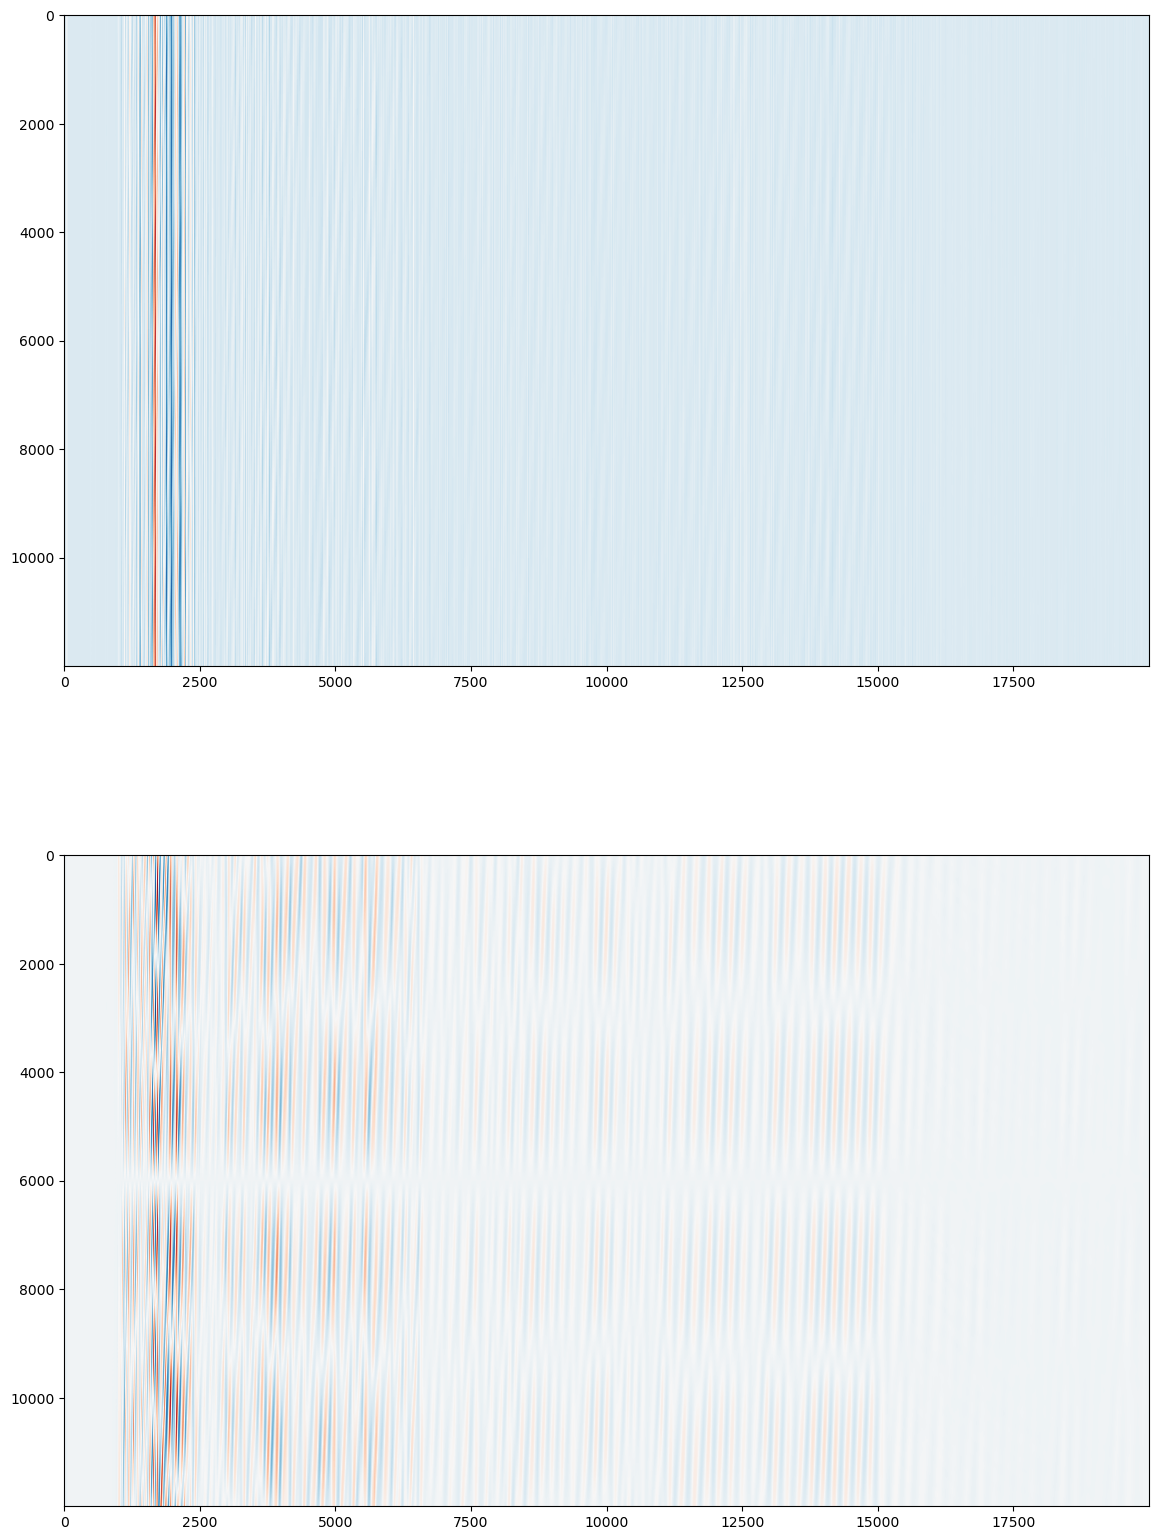

In [128]:
from matplotlib import pyplot as plt

fig,ax=plt.subplots(2,figsize=(14,20))
ax[0].imshow(a, cmap='RdBu')
ax[1].imshow(f, cmap='RdBu')
fig.show()

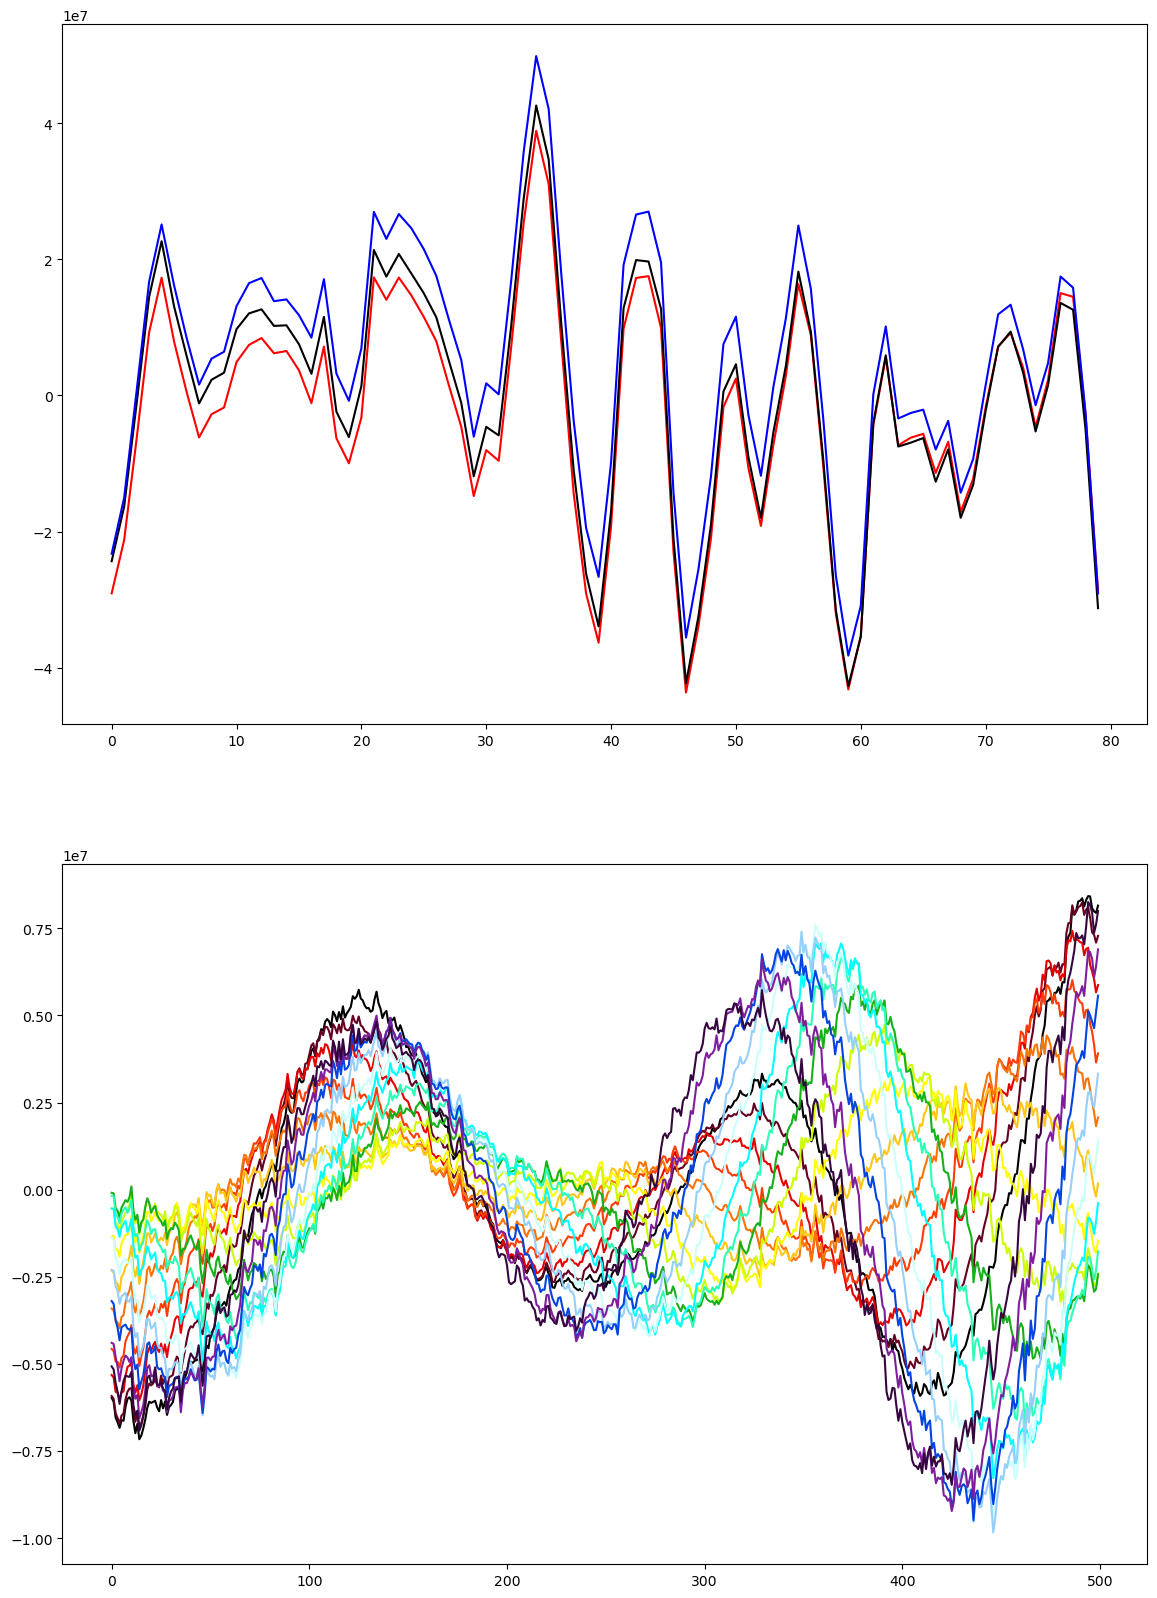

In [155]:
cols=['k', 'xkcd:maroon', 'xkcd:red', 'xkcd:red orange', 
      'xkcd:orange', 'xkcd:golden yellow', 'xkcd:bright yellow', 
      'xkcd:greenish yellow', 'xkcd:green', 'xkcd:greenish cyan', 
      'xkcd:cyan', 'xkcd:light light blue', 'xkcd:light blue', 
      'xkcd:blue', 'xkcd:purple', 'xkcd:dark purple']
ncols = len(cols)

fig,ax=plt.subplots(2,figsize=(14,20))

pulse0, pulseMid, pulseN = 0, 6000, 11999
pulseChan0, pulseChanN = 13820, 13900
ax[0].plot(a[pulse0,   pulseChan0:pulseChanN], c='r')
ax[0].plot(a[pulseMid, pulseChan0:pulseChanN], c='k')
ax[0].plot(a[pulseN,   pulseChan0:pulseChanN], c='b')

chanstart  = 12500
chanend    = 13000

pulsestart = 8000          # was 9000      # was 6000
pulseend   = 11000          # was 11000     #     8000
pulsestep  =  200

for i in range(pulsestart, pulseend + 1, pulsestep):
    j = (i - pulsestart)//pulsestep
    ax[1].plot(f[i,chanstart:chanend], c=cols[j%ncols])

fig.show()

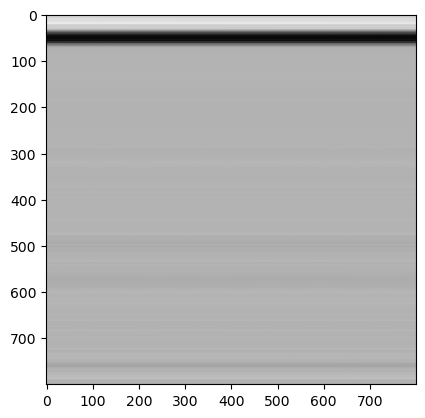

In [113]:
from matplotlib import pyplot as plt
fig,ax=plt.subplots()
ax.imshow(a, cmap='gray')

4000000

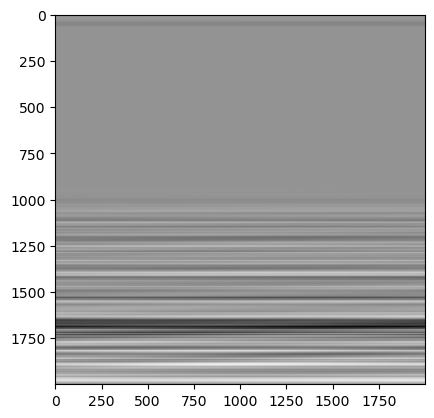

In [120]:
fig,ax=plt.subplots()
ax.imshow(a, cmap='gray')

In [143]:
# revisit this
a=ds.RawData[0:dlen,0:dwid].values
print(np.mean(a), np.std(a))
print(np.mean(a[0]), np.std(a[0]))
print(np.mean(a[1]), np.std(a[1]))
print(np.mean(a[1998]), np.std(a[1998]))
print(np.mean(a[1999]), np.std(a[1999]))

1210927.233731 56542560.87067221
14925703.415 55522.6627443585
6777299.0905 45656.65222061633
26364870.6735 10242412.027349293
34581675.5645 10322153.03162381


In [132]:
for i in range(wid):
    m = np.mean(a[i])
    b = [a[i][j] - m for j in range(wid)]
    a[i][:] = b

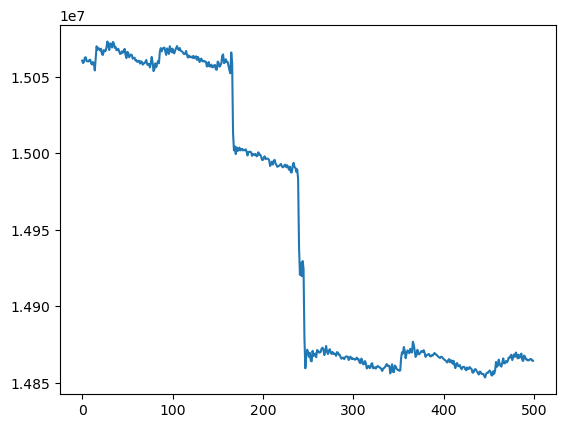

In [147]:
fig,ax=plt.subplots()
ax.plot(a[0][0:500])
fig.show()

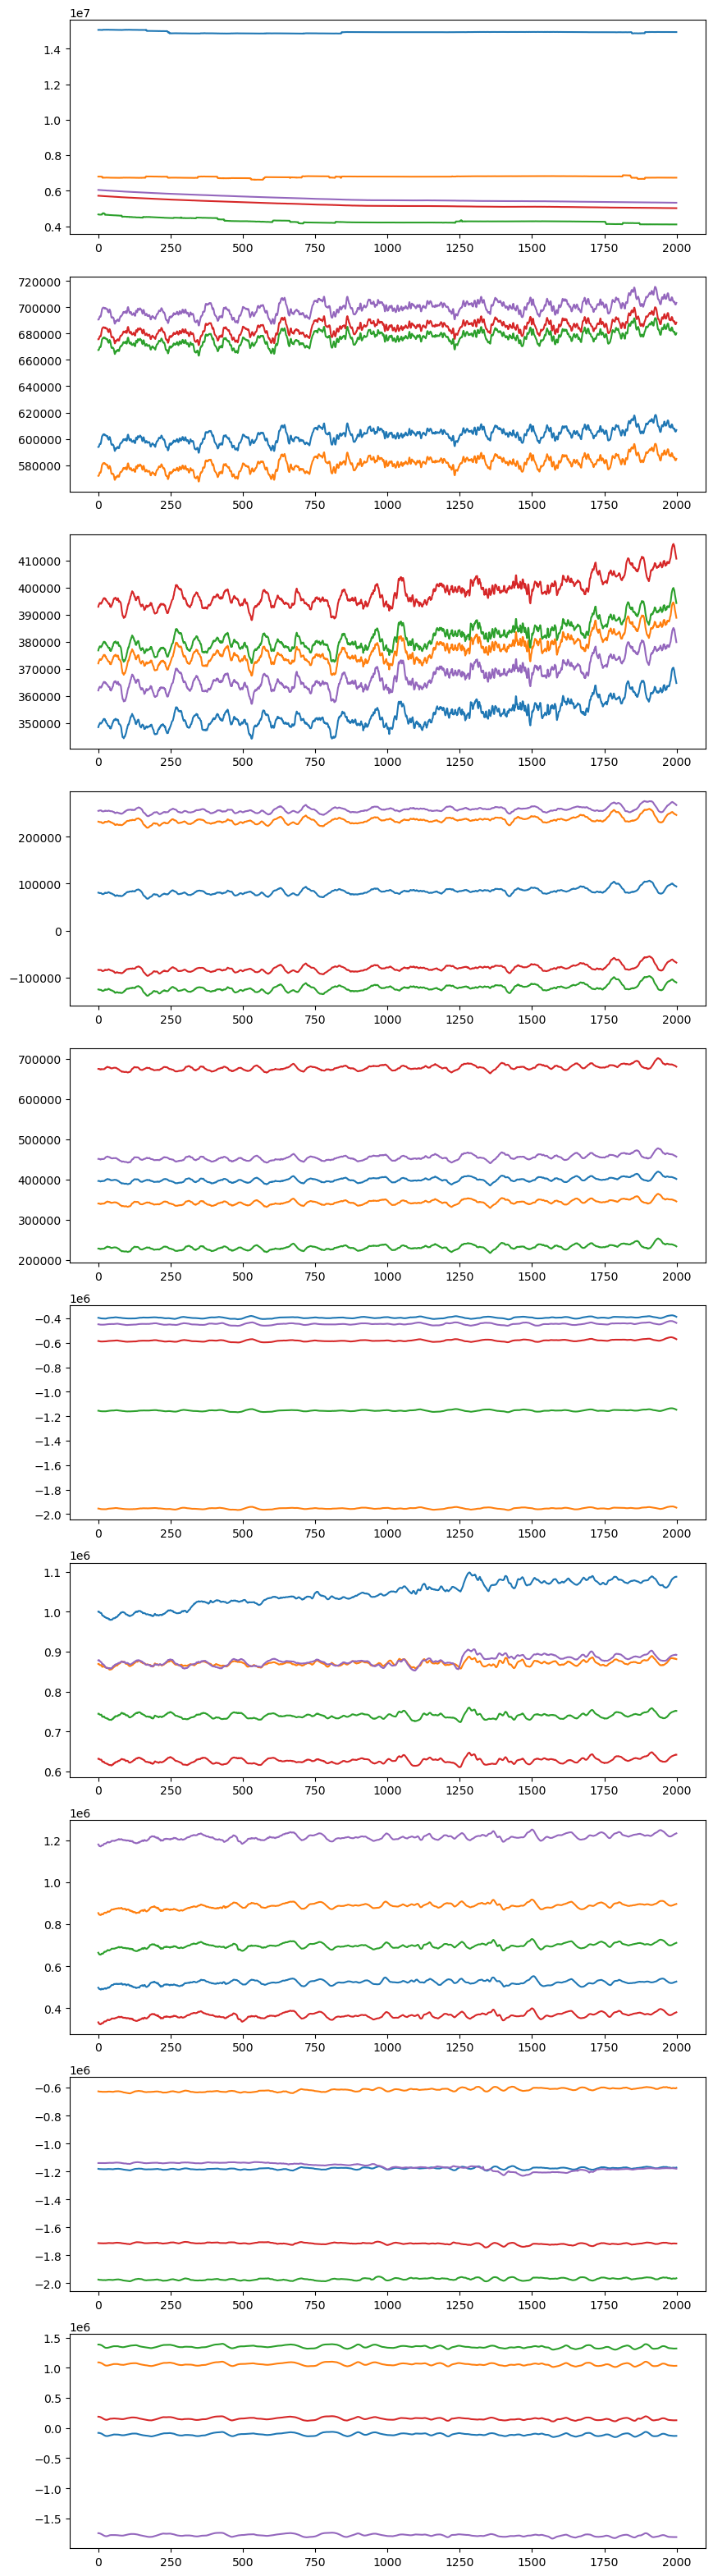

In [165]:
fig,ax=plt.subplots(10, figsize=(10,40))
for n in range(10):
    for i in range(n*100, n*100 + 5):
        ax[n].plot(a[i])
fig.show()